In [1]:
# !pip install mpl_finance
# !pip install yfinance

In [2]:
%matplotlib inline
from lstm import *
import numpy as np
import pandas as pd
import math
import sklearn
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
import os
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as mticker
from mpl_finance import candlestick_ohlc
import yfinance as yf

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt


from Constants import Consts

/Users/dean.meyer/opt/anaconda3/lib/python3.8/site-packages/mpl_finance.py:16: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  __warnings.warn('\n\n  ================================================================='+


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

# from google.colab import drive
# drive.mount('/content/drive')

device(type='cpu')

## Adding gold and VIX (Volatility Index) to augment our stock data

In [4]:
prev_5_years = (datetime.today() - timedelta(days=1825)).strftime('%Y-%m-%d')
today = datetime.today().strftime('%Y-%m-%d')

gold_etf = yf.Ticker('GLD')
gold_etf_data = gold_etf.history(start=prev_5_years, end=today, auto_adjust=True, actions=False)
gold_etf_data['date_timestamp'] = dates.date2num(gold_etf_data.index)
gold_etf_data

,Open,High,Low,Close,Volume,date_timestamp
Date,,,,,,
2015-12-28,102.480003,102.599998,102.029999,102.269997,3356200,735960.0
2015-12-29,102.519997,102.580002,102.110001,102.199997,2832200,735961.0
2015-12-30,101.470001,101.599998,101.349998,101.419998,3745000,735962.0
2015-12-31,101.480003,101.720001,101.309998,101.459999,3823600,735963.0
2016-01-04,103.129997,103.669998,102.489998,102.889999,6440000,735967.0
...,...,...,...,...,...,...
2020-12-18,176.649994,176.979996,176.100006,176.440002,6789900,737777.0
2020-12-21,176.289993,176.940002,175.759995,175.880005,8168900,737780.0
2020-12-22,176.199997,176.339996,174.339996,174.490005,9442400,737781.0


In [5]:
vix_index = yf.Ticker('^VIX')
vix_data = vix_index.history(start=prev_5_years, end=today, auto_adjust=True, actions=False)
vix_data['date_timestamp'] = dates.date2num(vix_data.index)
vix_data

,Open,High,Low,Close,Volume,date_timestamp
Date,,,,,,
2015-12-28,17.650000,18.129999,16.879999,16.910000,0,735960.0
2015-12-29,15.910000,16.480000,15.630000,16.080000,0,735961.0
2015-12-30,16.500000,17.420000,16.500000,17.290001,0,735962.0
2015-12-31,17.969999,20.389999,17.510000,18.209999,0,735963.0
2016-01-04,22.480000,23.360001,20.670000,20.700001,0,735967.0
...,...,...,...,...,...,...
2020-12-18,22.150000,23.770000,21.570000,21.570000,0,737777.0
2020-12-21,24.250000,31.459999,24.230000,25.160000,0,737780.0
2020-12-22,25.240000,25.559999,23.530001,24.230000,0,737781.0


In [6]:
apple = yf.Ticker('AAPL')
apple_data = apple.history(start=prev_5_years, end=today, auto_adjust=True, actions=False)
apple_data['date_timestamp'] = dates.date2num(apple_data.index)

first_date = apple_data.iloc[0].name

apple_data

,Open,High,Low,Close,Volume,date_timestamp
Date,,,,,,
2015-12-28,24.919764,24.942927,24.593184,24.741419,106816800,735960.0
2015-12-29,24.773845,25.345942,24.750684,25.186125,123724800,735961.0
2015-12-30,25.149068,25.176861,24.824803,24.857229,100855200,735962.0
2015-12-31,24.785424,24.790055,24.278180,24.380093,163649200,735963.0
2016-01-04,23.766309,24.405575,23.625022,24.400942,270597600,735967.0
...,...,...,...,...,...,...
2020-12-18,128.960007,129.100006,126.120003,126.660004,192541500,737777.0
2020-12-21,125.019997,128.309998,123.449997,128.229996,121251600,737780.0
2020-12-22,131.610001,134.410004,129.649994,131.880005,168904800,737781.0


In [7]:
apple_data['gold_close'] = gold_etf_data.Close
apple_data['vix_close'] = vix_data.Close

In [8]:
apple_data

,Open,High,Low,Close,Volume,date_timestamp,gold_close,vix_close
Date,,,,,,,,
2015-12-28,24.919764,24.942927,24.593184,24.741419,106816800,735960.0,102.269997,16.910000
2015-12-29,24.773845,25.345942,24.750684,25.186125,123724800,735961.0,102.199997,16.080000
2015-12-30,25.149068,25.176861,24.824803,24.857229,100855200,735962.0,101.419998,17.290001
2015-12-31,24.785424,24.790055,24.278180,24.380093,163649200,735963.0,101.459999,18.209999
2016-01-04,23.766309,24.405575,23.625022,24.400942,270597600,735967.0,102.889999,20.700001
...,...,...,...,...,...,...,...,...
2020-12-18,128.960007,129.100006,126.120003,126.660004,192541500,737777.0,176.440002,21.570000
2020-12-21,125.019997,128.309998,123.449997,128.229996,121251600,737780.0,175.880005,25.160000
2020-12-22,131.610001,134.410004,129.649994,131.880005,168904800,737781.0,174.490005,24.230000


In [9]:
apple_close_delta = apple_data.Close.diff()[1:]
apple_close_delta

Date
2015-12-29    0.444706
2015-12-30   -0.328896
2015-12-31   -0.477137
2016-01-04    0.020849
2016-01-05   -0.611471
                ...   
2020-12-18   -2.039993
2020-12-21    1.569992
2020-12-22    3.650009
2020-12-23   -0.919998
2020-12-24    1.009995
Name: Close, Length: 1258, dtype: float64

In [10]:
# Make the positive gains (up) and negative gains (down) Series
up, down = apple_close_delta.copy(), apple_close_delta.copy()
up[up < 0] = 0
down[down > 0] = 0

In [11]:
window_length = 14

# Calculate the EWMA
roll_up1 = up.ewm(span=window_length).mean()
roll_down1 = down.abs().ewm(span=window_length).mean()

# Calculate the RSI based on EWMA
RS1 = roll_up1 / roll_down1
RSI1 = 100.0 - (100.0 / (1.0 + RS1))
RSI1

Date
2015-12-29    100.000000
2015-12-30     53.956018
2015-12-31     30.470960
2016-01-04     31.964048
2016-01-05     18.511678
                 ...    
2020-12-18     61.991005
2020-12-21     66.910480
2020-12-22     75.438258
2020-12-23     70.178222
2020-12-24     72.598429
Name: Close, Length: 1258, dtype: float64

In [12]:
try:
    apple_data.drop(index=first_date, inplace=True)
except KeyError:
    pass

In [13]:
apple_data['RSI'] = RSI1
apple_data.head()

,Open,High,Low,Close,Volume,date_timestamp,gold_close,vix_close,RSI
Date,,,,,,,,,
2015-12-29,24.773845,25.345942,24.750684,25.186125,123724800,735961.0,102.199997,16.080000,100.000000
2015-12-30,25.149068,25.176861,24.824803,24.857229,100855200,735962.0,101.419998,17.290001,53.956018
2015-12-31,24.785424,24.790055,24.278180,24.380093,163649200,735963.0,101.459999,18.209999,30.470960
2016-01-04,23.766309,24.405575,23.625022,24.400942,270597600,735967.0,102.889999,20.700001,31.964048
2016-01-05,24.493589,24.516751,23.719986,23.789471,223164000,735968.0,103.180000,19.340000,18.511678


In [14]:
# Create a list of lists where each inner-list represents
# one day's trading history
apple = apple_data[[Consts.DATE_TIMESTAMP, Consts.OPEN, Consts.HIGH, 
                    Consts.LOW, Consts.CLOSE, Consts.VOLUME, 'gold_close', 'vix_close', 'RSI']]
apple_list = apple.values.tolist()

# Plot a candlestick chart for Apples stock

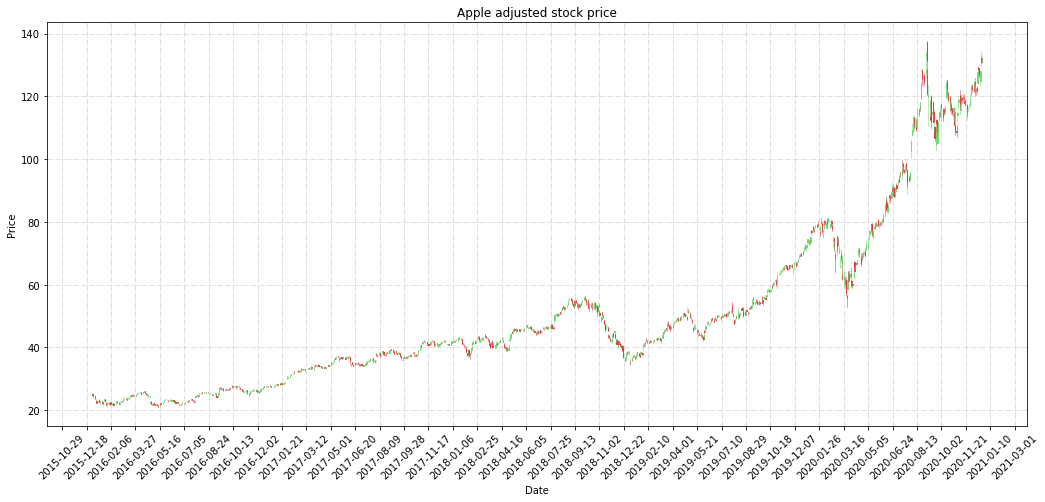

In [15]:

# Build the plot
fig = plt.figure(figsize=(16,8))
ax1 = plt.subplot2grid((1,1), (0,0))

candlestick_ohlc(ax1, apple_list, width=0.4, colorup='#77d879', colordown='#db3f3f',)

for label in ax1.xaxis.get_ticklabels():
     label.set_rotation(45)

ax1.xaxis.set_major_formatter(dates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mticker.MaxNLocator(50))
ax1.grid(True, alpha=0.5, linestyle='-.')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Apple adjusted stock price')
plt.subplots_adjust(left=0.09, bottom=0.20, right=0.94, top=0.90, wspace=0.2, hspace=0)
plt.show()

# Scaling the data

In [16]:
desired_columns = ['Open', 'High', 'Low', 'Close', 'Volume'] #, 'gold_close', 'vix_close', 'RSI']
close_idx = desired_columns.index('Close')
apple = apple[desired_columns]
apple

,Open,High,Low,Close,Volume
Date,,,,,
2015-12-29,24.773845,25.345942,24.750684,25.186125,123724800
2015-12-30,25.149068,25.176861,24.824803,24.857229,100855200
2015-12-31,24.785424,24.790055,24.278180,24.380093,163649200
2016-01-04,23.766309,24.405575,23.625022,24.400942,270597600
2016-01-05,24.493589,24.516751,23.719986,23.789471,223164000
...,...,...,...,...,...
2020-12-18,128.960007,129.100006,126.120003,126.660004,192541500
2020-12-21,125.019997,128.309998,123.449997,128.229996,121251600
2020-12-22,131.610001,134.410004,129.649994,131.880005,168904800


#### Split the data into training and testing sets

In [17]:
test_size = 365
data = apple.values

train_data = data[:-test_size]
test_data = data[-test_size:]

In [18]:
scaler = StandardScaler()

train_data = scaler.fit_transform(train_data)
train_data = torch.FloatTensor(train_data).to(device)

len(train_data), train_data[:3]

(893,
 tensor([[-1.2617, -1.2229, -1.2454, -1.2212, -0.1095],
         [-1.2226, -1.2404, -1.2376, -1.2555, -0.4970],
         [-1.2605, -1.2803, -1.2952, -1.3053,  0.5670]]))

In [19]:
scaler = StandardScaler()
test_data = scaler.fit_transform(test_data)
test_data = torch.FloatTensor(test_data).to(device)

len(test_data), test_data[:3]

(365,
 tensor([[-1.3159, -1.3243, -1.3041, -1.3085, -0.9613],
         [-1.2982, -1.3182, -1.3177, -1.3390, -0.8200],
         [-1.3194, -1.3110, -1.3050, -1.2929, -0.7403]]))

# Creating our data for training

In [20]:
# we split the data into 100 day sequences
seq_len = 100
train_seq = create_sequences(train_data, seq_len, close_idx)
print(f'There are {len(train_seq)} training sequences where each sequence has a shape of {train_seq[0][0].shape}')
print(f'and each sequence is paired with the closing price of the next day.')

There are 793 training sequences where each sequence has a shape of torch.Size([100, 5])
and each sequence is paired with the closing price of the next day.


In [21]:
test_seq = create_sequences(test_data, seq_len, close_idx)
print(f'There are {len(test_seq)} testing sequences where each sequence has a shape of {test_seq[0][0].shape}')
print(f'and each sequence is paired with the closing price of the next day.')

There are 265 testing sequences where each sequence has a shape of torch.Size([100, 5])
and each sequence is paired with the closing price of the next day.


In [22]:
model = LSTM_linear_before_after(len(desired_columns), 100, 1).to(device)
loss_function = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(model)

LSTM_linear_before_after(
  (fc2): Linear(in_features=5, out_features=32, bias=True)
  (lstm): LSTM(32, 100)
  (fc1): Linear(in_features=100, out_features=1, bias=True)
)


In [23]:
epochs = 15

loss_history = []
running_loss = []
for i in range(epochs):
    
    for j, (seq, label) in enumerate(train_seq):
        seq = seq.to(device)
        label = label.to(device)
        
        optimizer.zero_grad()

        model.h0 = torch.zeros(1, 1, model.hidden_size, device=device)
        model.c0 = torch.zeros(1, 1, model.hidden_size, device=device)

        y_pred = model(seq)

        loss = loss_function(y_pred, label)
        loss.backward()
        optimizer.step()

        running_loss.append(loss.item())

        if j % 50 == 0:
            avg_loss = sum(running_loss) / 50
            print(f'Epoch {i+1:3}, iteration {j:5}, loss: {avg_loss}')
            loss_history.append(avg_loss)
            running_loss = []

Epoch   1, iteration     0, loss: 0.044961042404174804


/Users/dean.meyer/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch   1, iteration    50, loss: 0.2012063203696016
Epoch   1, iteration   100, loss: 0.008750233851460508
Epoch   1, iteration   150, loss: 0.005033591882893234
Epoch   1, iteration   200, loss: 0.006796498511730534
Epoch   1, iteration   250, loss: 0.007419048644133
Epoch   1, iteration   300, loss: 0.01006282268199449
Epoch   1, iteration   350, loss: 0.009225586703423687
Epoch   1, iteration   400, loss: 0.029643884021788837
Epoch   1, iteration   450, loss: 0.04485105328422947
Epoch   1, iteration   500, loss: 0.058026648488250884
Epoch   1, iteration   550, loss: 0.017042137624248426
Epoch   1, iteration   600, loss: 0.0251994248159167
Epoch   1, iteration   650, loss: 0.06181430746997649
Epoch   1, iteration   700, loss: 0.09204944556709961
Epoch   1, iteration   750, loss: 0.08346238936930604
Epoch   2, iteration     0, loss: 0.22001336397137494
Epoch   2, iteration    50, loss: 1.0501324410015513
Epoch   2, iteration   100, loss: 0.005693755338508026
Epoch   2, iteration   15

In [26]:
## save model params
torch.save(model, "Model Info/Model_params")

In [30]:
the_model = torch.load("Model Info/Model_params")

Text(0, 0.5, 'loss')

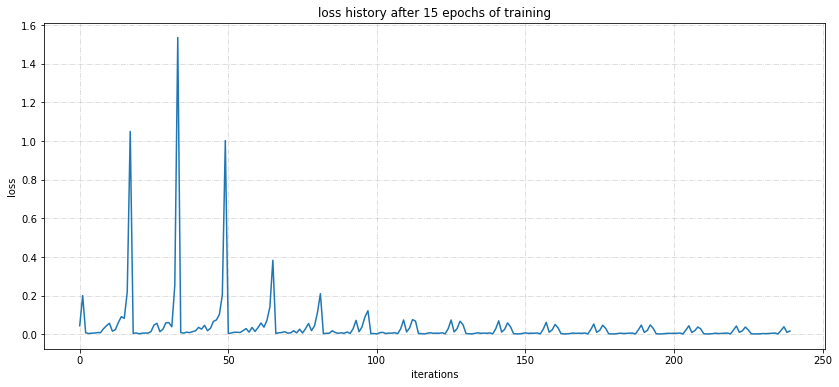

In [31]:
fig, ax1 = plt.subplots(1, 1, figsize=(14,6))

plt.title(f'loss history after {epochs} epochs of training')
ax1.plot(loss_history)
ax1.grid(alpha=.5, linestyle='-.')
plt.xlabel('iterations')
plt.ylabel('loss')

In [33]:
model = the_model
real_labels = []
predicted_labels = []
saved_values = []

with torch.no_grad():
    for i, (seq, label) in enumerate(test_seq):
        seq = seq.to(device)
        label = label.to(device)
        
        model.h0 = torch.zeros(1, 1, model.hidden_size, device=device) 
        model.c0 = torch.zeros(1, 1, model.hidden_size, device=device)

        # actual price
        real_labels.append(label)
        
        # predicted price
        predicted_labels.append(model(seq))
    
predicted_labels = np.array(predicted_labels)
real_labels = np.array(real_labels)

/Users/dean.meyer/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [34]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(real_labels, predicted_labels)

0.17197242

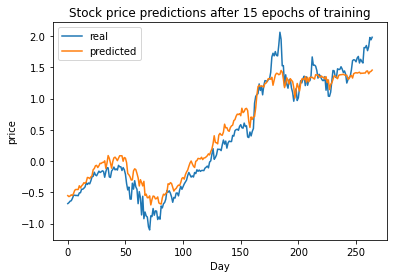

In [35]:

plt.title(f'Stock price predictions after {epochs} epochs of training')
plt.xlabel('Day')
plt.ylabel('price')
plt.plot(real_labels, label='real')
plt.plot(predicted_labels, label='predicted')
plt.legend();

# plt.savefig(f'/content/drive/My Drive/Deep Learning Final Project/{epochs}-epoch-preds1.jpg')

In [43]:
real_prices = real_labels * scaler.scale_[3] + scaler.mean_[3]
predicted_prices = predicted_labels * scaler.scale_[3] + scaler.mean_[3]

In [45]:
real_prices[-5:]

array([127.81, 128.7 , 126.66, 128.23, 131.88], dtype=float32)

In [46]:
predicted_prices[-5:]

array([117.18005, 117.91103, 118.00499, 117.03108, 117.58612],
      dtype=float32)

In [48]:
apple

,Open,High,Low,Close,Volume
Date,,,,,
2015-12-28,24.919764,24.942927,24.593184,24.741419,106816800
2015-12-29,24.773845,25.345942,24.750684,25.186125,123724800
2015-12-30,25.149068,25.176861,24.824803,24.857229,100855200
2015-12-31,24.785424,24.790055,24.278180,24.380093,163649200
2016-01-04,23.766309,24.405575,23.625022,24.400942,270597600
...,...,...,...,...,...
2020-12-16,127.410004,128.369995,126.559998,127.809998,98208600
2020-12-17,128.899994,129.580002,128.039993,128.699997,94359800
2020-12-18,128.960007,129.100006,126.120003,126.660004,192541500
